# Práctica de Calibración de cámaras

Máster Universitario en Visión Artificial, URJC <br>
Visión Tridimensional 2020-21 <br>
Practica 1. Marzo de 2021

Este enunciado está en el archivo "PracticaCalib2021_Alumnos.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* Calibrar una cámara usando el método de calibración de Zhang, implementado en OpenCV.
* Hacer uso de los resultados de la calibración para tomar diferentes medidas en las imágenes.
* Calibrar una cámara a partir de una imagen de una escena en la que se desconoce las coordenadas de sus puntos.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV.

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica``. Esta
carpeta contiene:
* Una secuencia de imágenes tomadas con una cámara de móvil en alta resolución en el directorio ``template4``.
* Un conjunto de imágenes de un edificio tomadas con el mismo móvil y resolución, ``building``.

## Condiciones

* La fecha límite de entrega será el viernes 16 de abril de 2021 a las 23:55 (en el Aula Virtual)
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``template4``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 21.5 mm en las direcciones X e Y.

In [1]:
%matplotlib notebook

import os
import cv2
import glob
import copy
import numpy as np
import matplotlib.pyplot as ppl

from sympy import *
from sympy.solvers import linsolve
from IPython.display import display, Latex, HTML

init_printing(use_latex='mathjax')

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una tupla con el primer elemento consistente en la lista de matrices de NumPy con las imágenes leídas y el segundo elemento la lista de nombres de fichero correspondientes.

In [2]:
def load_images(filenames):
    """Load multiple images."""
    # scipy.misc.imread is deprecated, 
    # using cv2.imread insted
    return zip(*[(cv2.imread(f), os.path.basename(f))
                 for f in filenames])

Usa ``load_images`` para cargar todas las imágenes del directorio ``template4`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

In [3]:
imgs, filenames = load_images(sorted(glob.glob('./template4/*')))

La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (9, 6) (*columnas x filas*). Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.

In [4]:
def find_corners(im: np.array) -> np.array:
    ret, corners = cv2.findChessboardCorners(im, (9, 6), None)
    return corners if ret else np.array([])

In [5]:
corners = [find_corners(i) for i in imgs]

In [6]:
def refine_corners(im: np.array, corner: np.array, criteria: tuple) -> np.array:
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    corned_refined = cv2.cornerSubPix(gray, corner, (11, 11), (-1,-1), criteria)
    return corned_refined

In [7]:
# This section is OPTIONAL
# cornerSubPix is destructive. so we copy standard corners and use the new list to refine
corners2 = copy.deepcopy(corners)

# Refine corner estimation (images mus be in b&w, use cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) to convert from rgb)
# termination criteria (see, e.g https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
cornersRefined = [refine_corners(i, c, criteria) for i, c in zip(imgs, corners2)]

El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

In [8]:
imgs2 = copy.deepcopy(imgs)

for img, cors in zip(imgs2, cornersRefined):
    cv2.drawChessboardCorners(img, (9, 6), cors, cors.size != 0)

<IPython.core.display.Javascript object>


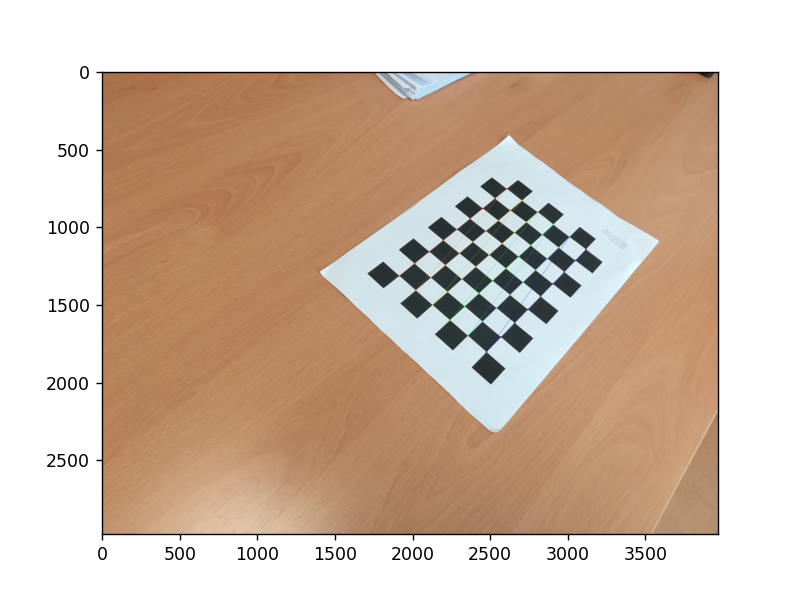

In [9]:
ppl.figure()
ppl.imshow(cv2.cvtColor(imgs2[0], cv2.COLOR_BGR2RGB))
ppl.show()

<IPython.core.display.Javascript object>


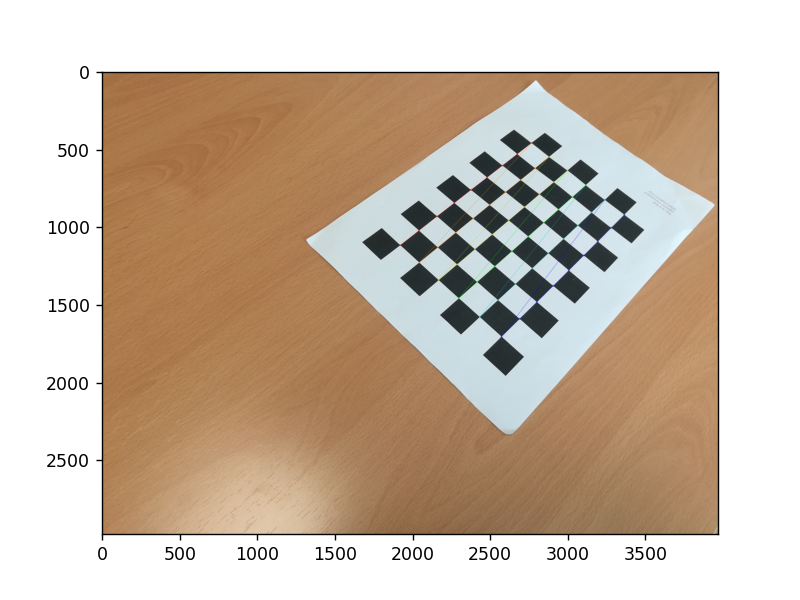

In [10]:
ppl.figure()
ppl.imshow(cv2.cvtColor(imgs2[1], cv2.COLOR_BGR2RGB))
ppl.show()

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un ndarray) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$, resp. (*columna, fila, 0*),  de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos (*columnas, filas*) de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (9, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 21.5 mm.

In [11]:
def get_chessboard_points(chessboard_shape, dx, dy):    
    h, w = chessboard_shape
    return np.array([[i * dx, j * dy, 0] 
                     for i in range(w) for j in range(h)])

cb_points = get_chessboard_points((9, 6), dx=21.5, dy=21.5)
print(cb_points)

[[  0.    0.    0. ]
 [  0.   21.5   0. ]
 [  0.   43.    0. ]
 [  0.   64.5   0. ]
 [  0.   86.    0. ]
 [  0.  107.5   0. ]
 [  0.  129.    0. ]
 [  0.  150.5   0. ]
 [  0.  172.    0. ]
 [ 21.5   0.    0. ]
 [ 21.5  21.5   0. ]
 [ 21.5  43.    0. ]
 [ 21.5  64.5   0. ]
 [ 21.5  86.    0. ]
 [ 21.5 107.5   0. ]
 [ 21.5 129.    0. ]
 [ 21.5 150.5   0. ]
 [ 21.5 172.    0. ]
 [ 43.    0.    0. ]
 [ 43.   21.5   0. ]
 [ 43.   43.    0. ]
 [ 43.   64.5   0. ]
 [ 43.   86.    0. ]
 [ 43.  107.5   0. ]
 [ 43.  129.    0. ]
 [ 43.  150.5   0. ]
 [ 43.  172.    0. ]
 [ 64.5   0.    0. ]
 [ 64.5  21.5   0. ]
 [ 64.5  43.    0. ]
 [ 64.5  64.5   0. ]
 [ 64.5  86.    0. ]
 [ 64.5 107.5   0. ]
 [ 64.5 129.    0. ]
 [ 64.5 150.5   0. ]
 [ 64.5 172.    0. ]
 [ 86.    0.    0. ]
 [ 86.   21.5   0. ]
 [ 86.   43.    0. ]
 [ 86.   64.5   0. ]
 [ 86.   86.    0. ]
 [ 86.  107.5   0. ]
 [ 86.  129.    0. ]
 [ 86.  150.5   0. ]
 [ 86.  172.    0. ]
 [107.5   0.    0. ]
 [107.5  21.5   0. ]
 [107.5  43. 

**Ejercicio 4.** Calibra la cámara usando la lista de resultados de ``cv2.findChessboardCorners`` y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior. 

In [12]:
# Extract the list of valid images with all corners
valid_corners = list(filter(lambda c: c.size > 0, cornersRefined))
num_valid_images = len(valid_corners)

# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_points = np.array([cb_points for _ in range(num_valid_images)], dtype=np.float32)
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_points = np.array([c.squeeze() for c in valid_corners], dtype=np.float32)

h, w = imgs[0].shape[:-1]

# Calibrate for square pixels corners standard
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    object_points, image_points, (h, w), None, None,
    flags=cv2.CALIB_FIX_ASPECT_RATIO
)

print("Corners standard intrinsics:\n", intrinsics)
print("\nCorners standard dist_coefs:\n", dist_coeffs)
print("\nrms:", rms)

Corners standard intrinsics:
 [[3.20010342e+03 0.00000000e+00 1.97743184e+03]
 [0.00000000e+00 3.20010342e+03 1.45272425e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Corners standard dist_coefs:
 [[ 3.15265489e-01 -2.37646542e+00 -1.28021740e-04 -5.40763919e-03
   4.80278266e+00]]

rms: 1.8763155101003073


Presta atención al parámetro de salida ``rms`` ¿qué significa este parámetro? ¿Se obtiene un valor razonable? ¿Qué pasa con el ``rms`` y la matriz de intrínsecos ``K`` si calibramos con las mismas imágenes pero con un tamaño de 1/4 del ancho y del alto? 

**Respuesta**

El ``rms`` (Root Mean Square) es el error de reproyección, utilizado para medir la calidad de la calibración. Cuanto más cercano a 0 quiere decir que mejor es la calibración de la cámara. Este error mejora con el número de imágenes, por lo que con estas imágenes se tiene un error de ``1.87``, lo cual es razonable ya que no hay muchas. 

Al modificar el parámetro ``Size`` a un cuarto de su tamaño, el ``rms`` se incrementa, así como los valores $f_x$, $f_y$, $c_x$ y $c_y$, estos dos últimos disparan su valor más del doble.

Sin embargo, si cargamos las imagenes y las redimensionamos a un cuarto de su tamaño, ``rms`` disminuye, pero también lo hace la focal, concretamente ``1/4``. 

**Ejercicio 5.** Implementa una función ``plotCamera3D(K, rvec, tvec, axes)`` que dibuje los ejes del sistema de referencia de la escena en 3D, el centro óptico de la cámara como un punto 3D y los ejes del sistema de referencia de la cámara expresados en el de la escena. A esta función se le pasan los intrínsecos (matriz $3x3$), y los extrínsecos: el vector de rotación ``rvec`` ($3x1$), y el vector de traslación ``tvec`` ($3x1$). El parámetro ``axes`` son los ejes de matplotlib configurados para dibujar en 3D. 

In [13]:
def plot3DPoints(Pts, axes):
    
    x = Pts[:, 0]
    y = Pts[:, 1]
    z = Pts[:, 2]
    
    axes.scatter3D(x, y, z, 'k')    
    

def plotCamera3D(K, rvec, tvec, axes=None, axis_len=100):
    
    if axes is None:
        axes = ppl.axes(projection = '3d')
        
    axis_zr = [0, 0, 0, 1]

    p3d = np.array([
        axis_zr, axis_zr, [axis_len, 0, 0, 1], 
        axis_zr, axis_zr, [0, axis_len, 0, 1], 
        axis_zr, axis_zr, [0, 0, axis_len, 1]
    ])

    p3d = p3d.T
    
    axes.plot3D(p3d[0, 0:3], p3d[1, 0:3], p3d[2, 0:3], 'r')
    axes.plot3D(p3d[0, 3:6], p3d[1, 3:6], p3d[2, 3:6], 'g')
    axes.plot3D(p3d[0, 6:9], p3d[1, 6:9], p3d[2, 6:9], 'b')
    
    # Descomponemos rvec en la matriz de Rotación
    R, _ = cv2.Rodrigues(rvec)
    
    # Obtenemos C_esc (coordenadas de la cámara en la escena - Camera points in World points)
    c_esc = np.dot(-R.T, tvec)     
    axes.scatter3D(*c_esc)

    # Obtenemos C_esc en C_cam (coordenadas de la cámara en la cámara)
    
    c_cam = R @ c_esc + tvec  # Este debería ser el punto [0, 0, 0]
                              # en coordenadas de la cámara.
    
    # Obtenemos los puntos de los ejes del sistema de 
    # referencia de la cámara (en coordenadas de la cámara)
    
    c_cam_x, c_cam_y, c_cam_z = c_cam
    
    # Se puede empezar desde aquí, simplemente declarando c_cam = [0, 0, 0].
    # Pero se hizo el cambio de arriba de C_esc -> C_cam para probar la teoría.
    
    mx = np.array([c_cam_x + axis_len, c_cam_y, c_cam_z])
    my = np.array([c_cam_x, c_cam_y + axis_len, c_cam_z])
    mz = np.array([c_cam_x, c_cam_y, c_cam_z + axis_len])
    
    # Convertimos los puntos del sistema de referencia de la cámara 
    # al sistema de referencia de la escena
    
    Mx = R.T @ (mx - tvec)
    My = R.T @ (my - tvec)
    Mz = R.T @ (mz - tvec)
    
    axes.plot3D([*c_esc[0], *Mx[0]], [*c_esc[1], *Mx[1]], [*c_esc[2], *Mx[2]], 'r')
    axes.plot3D([*c_esc[0], *My[0]], [*c_esc[1], *My[1]], [*c_esc[2], *My[2]], 'g')
    axes.plot3D([*c_esc[0], *Mz[0]], [*c_esc[1], *Mz[1]], [*c_esc[2], *Mz[2]], 'b')


<IPython.core.display.Javascript object>


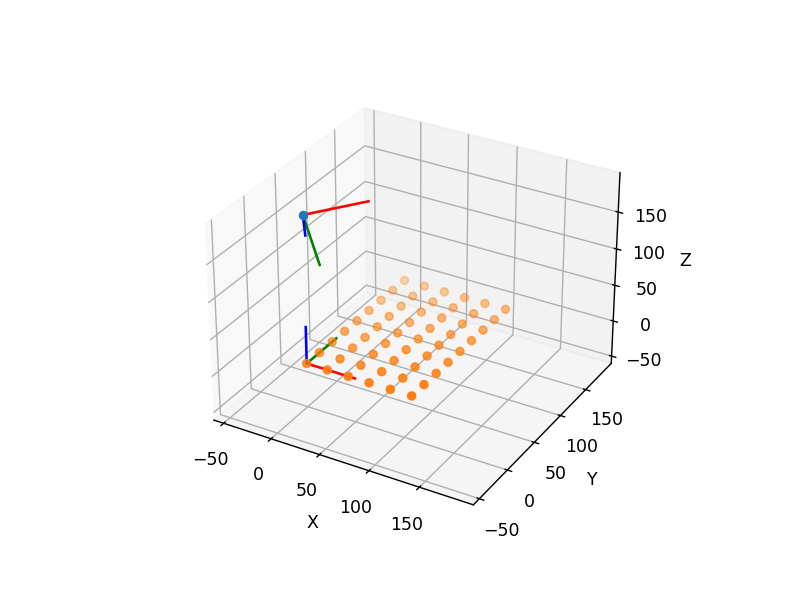

<IPython.core.display.Javascript object>


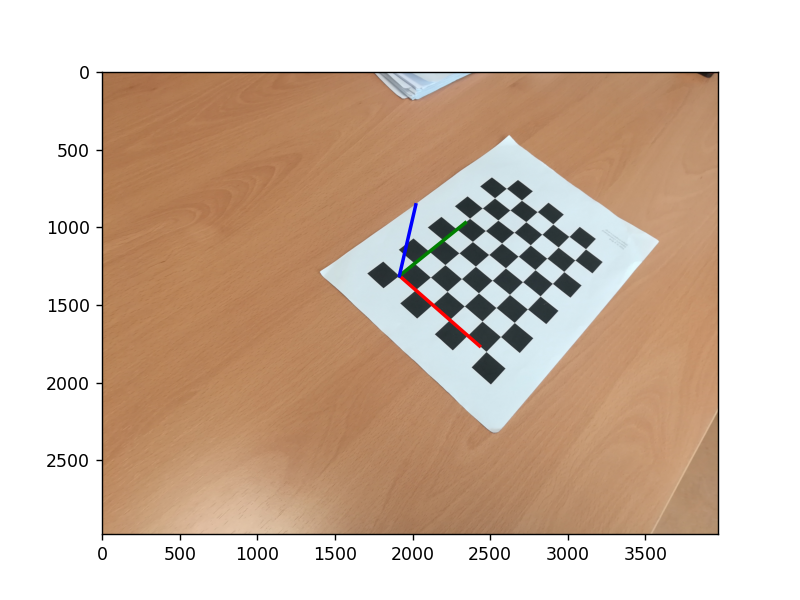

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Cambiar para una imagen de calibración diferente
image_index = 0
ppl.figure()
axes = ppl.axes(projection='3d')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_zlabel('Z')
plotCamera3D(intrinsics, rvecs[image_index], tvecs[image_index], axes, axis_len=50)
plot3DPoints(cb_points, axes) # pintar esquinas del "ajedrez" en 3D

# Importante para que los ejes 3D tengan las mismas proporciones en 
# matplotlib
scaling = np.array([getattr(axes, 'get_{}lim'.format(dim))() for dim in 'xyz'])
axes.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)
# Mostrar resultados en 3D
ppl.show()

R, _ = cv2.Rodrigues(rvecs[image_index])
P = np.dot(intrinsics, np.hstack((R, tvecs[image_index])))

p3d = np.array([[0, 0, 0, 1], [100, 0, 0, 1], [0, 0, 0, 1], 
                [0, 100, 0, 1], [0, 0, 0, 1], [0, 0, 100, 1]])
p3d = p3d.T

p2d = np.dot(P, p3d)
p2d = p2d / p2d[2, :]

ppl.figure()

ppl.plot(p2d[0, 0:2], p2d[1, 0:2], '-r', linewidth=2)
ppl.plot(p2d[0, 2:4], p2d[1, 2:4], '-g', linewidth=2)
ppl.plot(p2d[0, 4:6], p2d[1, 4:6], '-b', linewidth=2)

ppl.imshow(cv2.cvtColor(imgs[image_index], cv2.COLOR_BGR2RGB))
ppl.show()

Usando la función desarrollada, ``plotCamera3D``, pintar en 3D los ejes del sistema de referencia de la escena, los puntos de la plantilla de calibración y todas las cámaras que tomaron las imágenes en ``template4``.

<IPython.core.display.Javascript object>


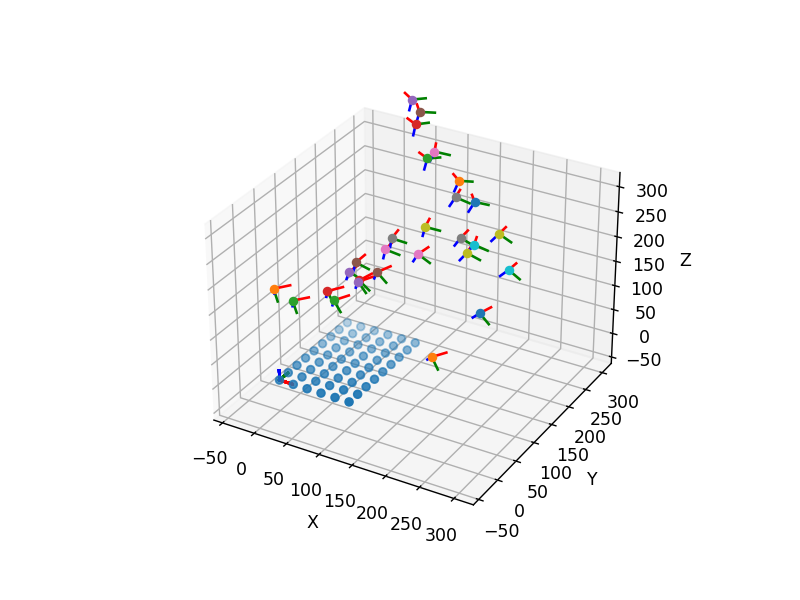

In [15]:
ppl.figure()
axes = ppl.axes(projection='3d')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_zlabel('Z')
plot3DPoints(cb_points, axes) # pintar esquinas del "ajedrez" en 3D

for i in range(len(rvecs)):
    plotCamera3D(intrinsics, rvecs[i], tvecs[i], axes, axis_len=20)

scaling = np.array([getattr(axes, 'get_{}lim'.format(dim))() for dim in 'xyz'])
axes.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)
ppl.show()

###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 6.** Conociendo los intrínsecos K y el tamaño en píxeles de la imagen, calcula el ángulo de visión horizontal de la cámara (el relacionado con el ancho de la imagen).


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

**Respuesta**

Teniendo los intrinsecos: 

$$K =
\begin{bmatrix}
f_{x} &  s &  c_{x}\\ 
0 & f_{y} & c_{y}\\ 
0 & 0 & 1
\end{bmatrix}
$$

Donde:

 - $f_{x}, f_{y}$ son las distancias focales en x e y. Que en este caso son iguales.

In [16]:
# Get the fx and fy values from K.
fx, fy = intrinsics[0, 0], intrinsics[1, 1]
# Check they are equals.
fx == fy

True

Para calcular el ángulo de visión horizontal, $fov_{x}$, a partir del ancho de la imagen, $w$ tenemos, partiendo el ángulo a calcular en dos y teniendo un triángulo rectángulo con catetos $f_{x}$ (adyacente) y $w / 2$ (opuesto), lo mismo aplicaría para el ángulo vertical:

$$fov_{x} = 2 * arctan \frac{w}{2f_{x}} \qquad fov_{y} = 2 * arctan \frac{h}{2f_{y}}$$

In [17]:
# Calcula el fov y convierte el resultado en grados. 
fov = lambda x, f: 2 * np.arctan(x / (2 * f)) * 180 / np.pi

In [18]:
print("El ángulo de visión horizontal es de:", fov(w, fx), "grados")

El ángulo de visión horizontal es de: 63.59616715971159 grados


**Ejercicio 7.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición $(15, 15)$ y tiene un tamaño de $(50, 50)$ píxeles, calcula el ángulo de visión diagonal que abarca dicha región.


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

**Respuesta**

Para calcular el ángulo de visión bastaría con trazar dos rayos que vayan del punto $(0, 0, 0)$ (centro óptico de la cámara) a los puntos $(15, 15)$ y $(65, 65)$ en la imagen deseados. Y después, una vez teniedos esos vectores calcular el ángulo utilizando las propiedades del producto escalar.

Digamos que tenemos dos vectores, $u$ y $v$, pues, el ángulo que forman viene dada por la expresión:

$$\widehat{u, v} = cos^{-1}\frac{\langle u, v \rangle}{\left\|u\right\|\left\|v\right\|}$$

<IPython.core.display.Javascript object>


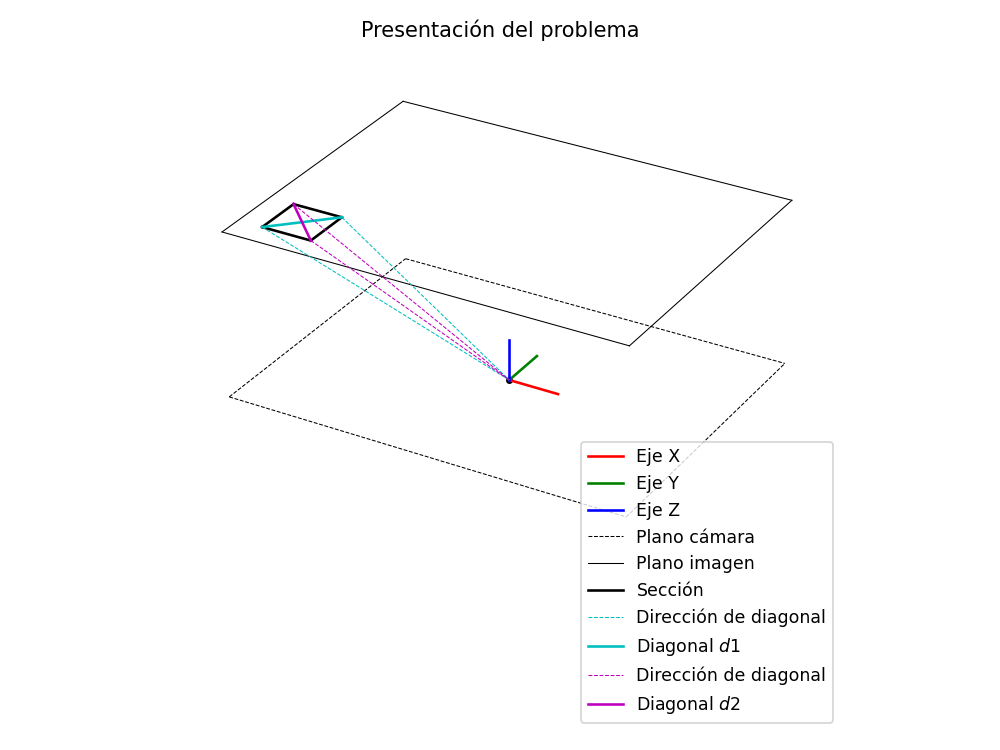

In [19]:
# Visualización del problema.
# Para esta visualización se han modificado las dimensiones
# para una mejor visualización del mismo.

w_, h_, f_ = 800, 600, 400

ppl.figure(figsize=(8, 6))
axes = ppl.axes(projection='3d')

# Plot origen de coordenadas.
axes.plot3D(0, 0, 0, 'k.')

# Plot ejes del origen de coordenadas
axes.plot3D([0, 100], [0, 0], [0, 0], 'r-', label='Eje X')
axes.plot3D([0, 0], [0, 100], [0, 0], 'g-', label='Eje Y')
axes.plot3D([0, 0], [0, 0], [0, 100], 'b-', label='Eje Z')

# Plot plano de la cámara
axes.plot3D([-w_/2, w_/2], [-h_/2, -h_/2], [0, 0], 'k--', linewidth=0.6, label='Plano cámara')
axes.plot3D([-w_/2, w_/2], [h_/2, h_/2], [0, 0], 'k--', linewidth=0.6)
axes.plot3D([w_/2, w_/2], [-h_/2, h_/2], [0, 0], 'k--', linewidth=0.6)
axes.plot3D([-w_/2, -w_/2], [-h_/2, h_/2], [0, 0], 'k--', linewidth=0.6)

# Plot plano de la imagen
axes.plot3D([-w_/2, w_/2], [-h_/2, -h_/2], [f_,f_], 'k-', linewidth=0.6, label='Plano imagen')
axes.plot3D([-w_/2, w_/2], [h_/2, h_/2], [f_,f_], 'k-', linewidth=0.6)
axes.plot3D([w_/2, w_/2], [-h_/2, h_/2], [f_,f_], 'k-', linewidth=0.6)
axes.plot3D([-w_/2, -w_/2], [-h_/2, h_/2], [f_,f_], 'k-', linewidth=0.6)

# Plot sección
p1_ = [-w_/2 + 50, -h_/2 + 50, f_]   # Punto simulado [15, 15] 
p2_ = [-w_/2 + 50, -h_/2 + 150, f_]  # Punto simulado [15, 65] 
p3_ = [-w_/2 + 150, -h_/2 + 50, f_]  # Punto simulado [65, 15]
p4_ = [-w_/2 + 150, -h_/2 + 150, f_] # Punto simulado [65, 65]

axes.plot3D([p1_[0], p2_[0]],[p1_[1], p2_[1]], [p1_[2], p2_[2]], 'k-', label='Sección')
axes.plot3D([p4_[0], p2_[0]],[p4_[1], p2_[1]], [p4_[2], p2_[2]], 'k-')
axes.plot3D([p1_[0], p3_[0]],[p1_[1], p3_[1]], [p1_[2], p3_[2]], 'k-')
axes.plot3D([p3_[0], p4_[0]],[p3_[1], p4_[1]], [p3_[2], p4_[2]], 'k-')

# Plot direcciones

axes.plot3D([p1_[0], 0], [p1_[1], 0], [p1_[2], 0], 'c--', label='Dirección de diagonal', linewidth=0.6)
axes.plot3D([p4_[0], 0], [p4_[1], 0], [p4_[2], 0], 'c--', linewidth=0.6)
axes.plot3D([p1_[0], p4_[0]], [p1_[1], p4_[1]], [p1_[2], p4_[2]], 'c-', label=r'Diagonal $d1$')

axes.plot3D([p2_[0], 0], [p2_[1], 0], [p2_[2], 0], 'm--', label='Dirección de diagonal', linewidth=0.6)
axes.plot3D([p3_[0], 0], [p3_[1], 0], [p3_[2], 0], 'm--', linewidth=0.6)
axes.plot3D([p2_[0], p3_[0]], [p2_[1], p3_[1]], [p2_[2], p3_[2]], 'm-', label=r'Diagonal $d2$')

scaling = np.array([getattr(axes, 'get_{}lim'.format(dim))() for dim in 'xyz'])
axes.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)

axes.legend(loc='lower right')
axes.axis('off'); ppl.title("Presentación del problema"); ppl.tight_layout()

In [20]:
# Definimos los puntos que conforman las esquinas de la sección.
p1 = np.array([-w/2 + 15, -h/2 + 15, fx])  # Punto [15, 15] representado en el sistema de la cámara
p2 = np.array([-w/2 + 15, -h/2 + 65, fx])  # Punto [15, 65] representado en el sistema de la cámara
p3 = np.array([-w/2 + 65, -h/2 + 15, fx])  # Punto [65, 15] representado en el sistema de la cámara
p4 = np.array([-w/2 + 65, -h/2 + 65, fx])  # Punto [65, 65] representado en el sistema de la cámara

In [21]:
# Calula el ángulo entre dos vectores en grados.
fov_uv = lambda u, v: np.arccos((u @ v) / (np.linalg.norm(u) * np.linalg.norm(v))) * 180 / np.pi

In [22]:
print("El ángulo de visión diagonal entre (15, 15) y (65, 65) es de:", fov_uv(p1, p4), "grados")
print("El ángulo de visión diagonal entre (65, 15) y (15, 65) es de:", fov_uv(p2, p3), "grados")

El ángulo de visión diagonal entre (15, 15) y (65, 65) es de: 0.809279314050741 grados
El ángulo de visión diagonal entre (65, 15) y (15, 65) es de: 1.0053045329674015 grados


**Ejercicio 8.** En las imágenes tomadas por dispositivos digitales se almacena información sobre la cámara que tomó la foto en un formato denominado [EXIF](https://es.wikipedia.org/wiki/Exchangeable_image_file_format). Esta información se puede leer con programas de retoque fotográfico libres como [GIMP](https://www.gimp.org/downloads/).

Dados los intrísecos en K del proceso de calibración, y sabiendo que el móvil que tomó la foto es un modelo Honor 6X con un sensor Sony IMX386 calcular la focal en mm de la cámara a partir de K. Se pide comparar el resultado con la información EXIF de las imágenes.


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

**Respuesta**

Utilizando la página [exifdata.com](https://www.exifdata.com/exif.php) que permite la visualización online de la información *EXIF* se extrae que:

$$ Distancia\ Focal = 3.8 mm$$

Aunque en las propiedades que ofrece el sistema operativo *Windows 10* sobre la distancia focal consta que es de $4.0\ mm$

La idea para calcular dicha distancia ($F_{x}$ y $F_{y}$), desde $K$ es extraer los focales en píxeles $f_{x}$ y $f_{y}$ y convertirlos a milímetros. Para realizar esa conversión se necesitan las dimensiones del sensor ($w_{sensor}$, $h_{sensor}$) y las dimensiones de la imágenes que captura ($w_{image}$, $h_{image}$). Esta relación quedaría:

$$\frac{F(mm)}{f(px)} = \frac{w_{sensor}(mm)}{w_{image}(px)}$$

$$F(mm) = f(px) * \frac{w_{sensor}(mm)}{w_{image}(px)}$$

La relación $\frac{w_{sensor}(mm)}{w_{image}(px)}$ es la relación de conversión de las unidades $mm$ a $px$ y viceversa. Esta relación se puede entender como el tamaño de un píxel en $mm$. Justo esta es la medida que ofrece el fabricante al buscar las especificaciones del sensor Sony IMX386 y resulta ser de $1.25\ micras$. Es decir, cada pixel tiene un tamaño de 1.25 micrómetros. Y, como solo tenemos una medida, asumimos que el pixel es cuadrado, por lo que si denotamos dicha medida como $imx386 = 1e-3$ (ya que $1\mu m = 1e-3mm$) quedaría.

$$F(mm) = f(px) * imx386 \left ( \frac{mm}{px} \right )$$

In [23]:
imx386 = 1.25e-3 # mm/px.
F = fx * imx386

print("Distancia focal =", F , "mm")

Distancia focal = 4.000129270659896 mm


**Ejercicio 9.** Calcula cuánto se ha trasladado la cámara entre las imágenes ``IMG_20201019_141223.jpg``  y ``IMG_20201019_141235_1.jpg``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

**Respuesta**

Para saber cuánto se ha trasladado una cámara entre imágenes basta con calcular la distancia entre los centros ópticos de las cámaras.

Para hayar el centro óptico en coordenadas de la escena teniendo la matriz de rotación $R$ y el vector de traslación $t$ tenemos:

$$ C_{esc} = - R^{T}t$$

Por lo que si el centro óptico de la imagen $A$ es $C_{esc}^A$ y el de la imagen $B$ es $C_{esc}^B$ tenemos:

$$ dist(C_{esc}^A, C_{esc}^B)
=
\begin{Vmatrix}
C_{esc}^A - C_{esc}^B
\end{Vmatrix}
$$

Donde $C_{esc}^A$ y $C_{esc}^B$ son vectores columna.

In [24]:
# Anotar los nombres de las imágenes
im_a_name, im_b_name = 'IMG_20201019_141223.jpg', 'IMG_20201019_141235_1.jpg'

# Buscar las imágenes cargadas por el nombre.
im_a_i, im_b_i = filenames.index(im_a_name), filenames.index(im_b_name)
im_a, im_b = imgs[im_a_i], imgs[im_b_i]

<IPython.core.display.Javascript object>


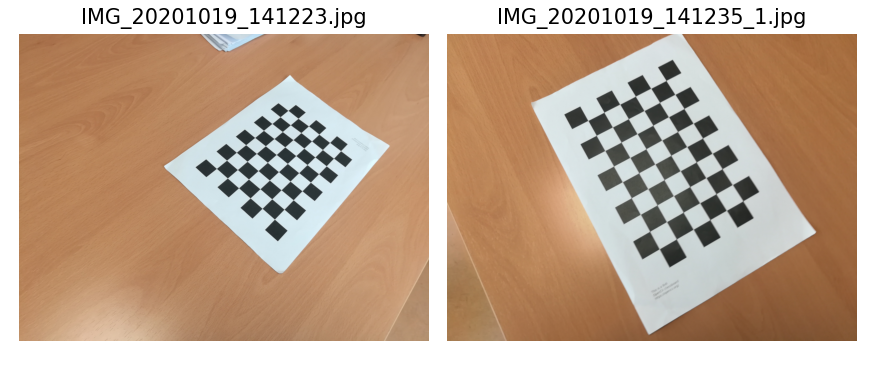

In [25]:
# Mostrar las imágenes con las que se quiere trabajar.
ppl.figure(figsize=(7, 3))
ax1, ax2 = ppl.subplot(1, 2, 1), ppl.subplot(1, 2, 2)
ax1.imshow(cv2.cvtColor(im_a, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(im_b, cv2.COLOR_BGR2RGB))
ax1.axis('off'); ax1.set_title(im_a_name); ax2.axis('off'); ax2.set_title(im_b_name)
ppl.tight_layout(); ppl.show()

In [26]:
# Recuperar los rvecs y tvecs correspoindientes de la calibración
rvec_a, rvec_b = rvecs[im_a_i], rvecs[im_b_i]
tvec_a, tvec_b = tvecs[im_a_i], tvecs[im_b_i]

# Extraer las matrices de rotación 
# y calcular las coordenas de la cámara en la escena
(R_a, _), (R_b, _) = cv2.Rodrigues(rvec_a), cv2.Rodrigues(rvec_b)
C_esc_a, C_esc_b = np.dot( -R_a.T, tvec_a ), np.dot( -R_b.T, tvec_b )

# Calcular la distanca como la norma entre los centros
dist_ab = np.linalg.norm(C_esc_a - C_esc_b)

print("Distancia entre imágenes:", dist_ab, "mm")

Distancia entre imágenes: 408.5640046752253 mm


## 2. Calibración a partir de una imagen

En esta sección vamos a explotar las relaciones de perpendicularidad que suelen aparecer en las escenas urbanas para calibrar la cámara y extraer información sobre dicha escena.

En el directorio ``building`` hay varias imágenes de un edificio que ha sido tomadas con la misma cámara.

**Ejercicio 10.** Se desea estimar los intrínsecos de la cámara a partir de una imagen (cualquiera de las imágenes en ``building``).

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico. Comparar el resultado con la K obtenida calibrando la cámara con el algoritmo de OpenCV.

Sugerencia: Localizar direcciones ortogonales en la escena y sus puntos de fuga asociados.

**Respuesta**

Para calibrar una cámara sin plantilla de calibración podemos tomar, a partir de una imagen, aquellas líneas paralelas en el mundo real y encontrar su intersección. Con estos puntos, por ejemplo, uno por eje, tendríamos $v_1$, $v_2$ y $v_3$, con la equación que relaciona dichos puntos en la imagen con su proyección en el infinto $v_i^T\omega v_j = 0$ y sabiendo las propiedades de $\omega$ es una matriz simétrica se puede llegar a formar un sistema de 3 ecuaciones con 3 incógnitas. Una vez se tiene $\omega$ se puede llegar a extraer $K$ realizando Cholesky, sabiendo que $\omega = K^{-T}K^{-1}$.

**Nota I:** Todos estos pasos se van a mostrar al final, con la librería *Sympy*.

**Nota II:** Las líneas interesantes se han obtenido con un etiquetado manual (por cuestiones de tiempo) utilizando el programa [LabelImg](https://github.com/tzutalin/labelImg).

In [27]:
def line_from_2_points(p0, p1):
    
    # Obtiene los coheficientes a, b y c de la
    # recta que pasa por los puntos p0 y p1 y los
    # devuelve en forma de vector fila. 
    
    return np.cross(p0  + [1, ], p1 + [1, ]).astype(np.int64)
    

def get_lines(path):
    
    # Lee las rectas encontradas en path en un diccionario
    # que contiene las claves x, y, z y como elemento la lista
    # con las rectas paralelas a esos ejes. 
    
    import xmltodict
    with open(path) as xml_annotations:
        data = xmltodict.parse(xml_annotations.read())
    
    lines, points = {"x": [], "y": [], "z": []}, {"x": [], "y": [], "z":[]}
    
    for obj in data.get('annotation').get('object'):
        name, coords = obj.get('name'), obj.get('bndbox')
        if name in ['x', 'zx']:
            p0, p1 = [int(coords.get('xmin')), int(coords.get('ymin'))], [int(coords.get('xmax')), int(coords.get('ymax'))]
        if name in ['y', 'zy']:
            p0, p1 = [int(coords.get('xmin')), int(coords.get('ymax'))], [int(coords.get('xmax')), int(coords.get('ymin'))]
        
        lines.get(name[0]).append(line_from_2_points(p0, p1))
        points.get(name[0]).append([p0, p1])
    
    return lines, points

In [28]:
# Cargamos las imágenes
imgs, filenames = load_images(sorted(glob.glob('./building/*')))

In [29]:
img_index = 0

img = imgs[img_index]
lines, points = get_lines(f"./building/{filenames[img_index].replace('jpg', 'xml')}")

In [30]:
xlines, xpoints = lines.get('x'), points.get('x')
ylines, ypoints = lines.get('y'), points.get('y')
zlines, zpoints = lines.get('z'), points.get('z')

In [31]:
# Organize rects
(lx1, lx2) = xlines
(ly1, ly2) = ylines
(lz1, lz2) = zlines 

In [32]:
# Intersecciones de las paralelas X
p_x = np.cross(lx1, lx2); p_x = p_x / p_x[2]

# Intersecciones de las paralelas Y
p_y = np.cross(ly1, ly2); p_y = p_y / p_y[2]

# Intersecciones de las paralelas Z
p_z = np.cross(lz1, lz2); p_z = p_z / p_z[2]

# Línea del horizonte
l_horiz = np.cross(p_x, p_y)

In [33]:
# Ordenar los puntos para que plotting sea más fácil
lpx0 = sorted(xpoints[0], key=lambda x: x[1])
lpx1 = sorted(xpoints[1], key=lambda x: x[1])
lpy0 = sorted(ypoints[0], key=lambda x: x[1])
lpy1 = sorted(ypoints[1], key=lambda x: x[1])
lpz0 = sorted(zpoints[0], key=lambda x: x[0])
lpz1 = sorted(zpoints[1], key=lambda x: x[0])

<IPython.core.display.Javascript object>


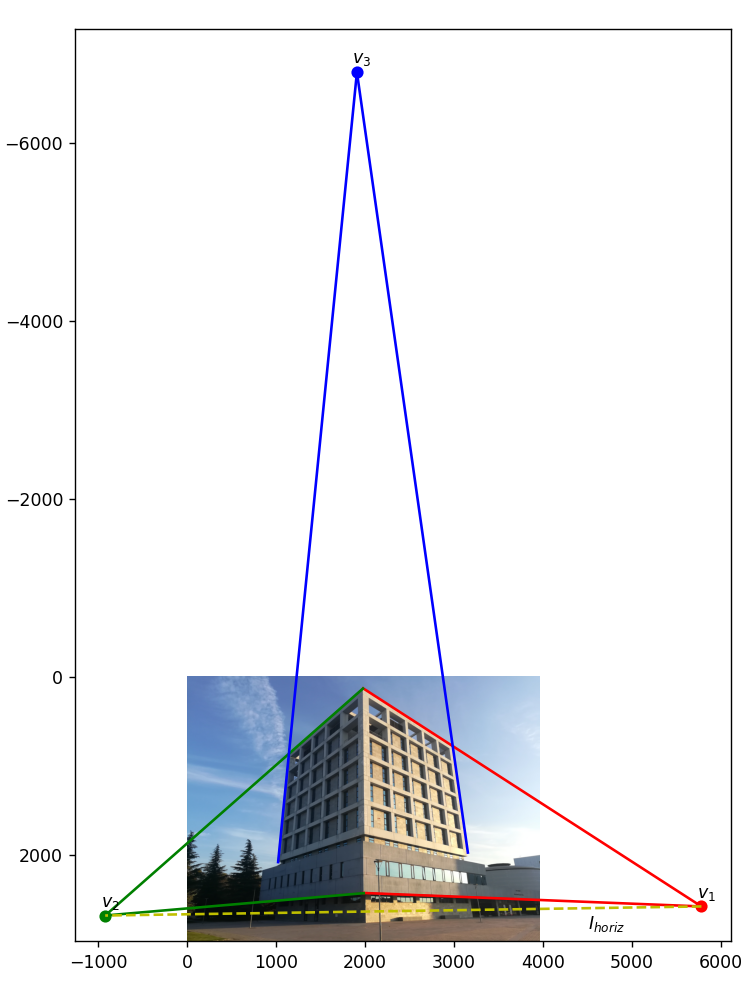

In [34]:
# Mostrar las líneas y los puntos de corte, así como la
# línea del horizonte obtenida.

ppl.figure(figsize=(6, 8))
ppl.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Plot de los puntos de corte en el infinitos traídos al plano imagen.
ppl.plot(p_x[0], p_x[1], 'ro'); ppl.text(p_x[0] - 50, p_x[1] - 100, r'$v_{1}$')
ppl.plot(p_y[0], p_y[1], 'go'); ppl.text(p_y[0] - 50, p_y[1] - 100, r'$v_{2}$')
ppl.plot(p_z[0], p_z[1], 'bo'); ppl.text(p_z[0] - 50, p_z[1] - 100, r'$v_{3}$')

# Plot de las rectas de paralelas
ppl.plot([p_x[0], lpx0[0][0]], [p_x[1], lpx0[0][1]], 'r'); ppl.plot([p_x[0], lpx1[0][0]], [p_x[1], lpx1[0][1]], 'r')
ppl.plot([p_y[0], lpy0[0][0]], [p_y[1], lpy0[0][1]], 'g'); ppl.plot([p_y[0], lpy1[0][0]], [p_y[1], lpy1[0][1]], 'g')
ppl.plot([p_z[0], lpz0[0][0]], [p_z[1], lpz0[0][1]], 'b'); ppl.plot([p_z[0], lpz1[1][0]], [p_z[1], lpy1[0][0]], 'b')

# Plot de la línea del horizonte
ppl.plot([p_x[0], p_y[0]], [p_x[1], p_y[1]], '--y'); ppl.text(4500, p_x[1] + 250, r'$I_{horiz}$')

ppl.tight_layout()
ppl.show()

In [35]:
# Declaramos los puntos de fuga "símbolos" a partir
# de los puntos de corte antes calculados.
v1, v2, v3 = symbols('v1 v2 v3')
v1, v2, v3 = (Matrix(p_x), Matrix(p_y), Matrix(p_z))

# Declaramos los elementos simétricos de la matriz w 
# que se necesitan calcular. 
w1, w4, w5 = symbols('w1 w4 w5')

# Formamos la matriz w con dichos elementos.
w = Matrix([[w1, 0, w4], [0, w1, w5], [w4, w5, 1]])

# Creamos las ecuaciones que conformarán el sistema 3x3
q0, q1, q2 = (v1.T * w * v2, v1.T * w * v3, v2.T * w * v3)

# Conformamos el sistema
system = [*q0, *q1, *q2]

# Calculamos la solución
solution = linsolve(system, w1, w4, w5)
sw1, sw4, sw5 = tuple(*solution)

# Sustituimos en w los valores obtenidos
sw = w.subs([(w1, sw1), (w4, sw4), (w5, sw5)])

# Para sacar K necesitamos sacar K^-T desde w aplicando Cholesky
k_inv_t = sw.cholesky()
K_ = k_inv_t.T.inv()
K = K_ / K_[2, 2]

In [36]:
# Cambiar valor para ajustar los decimales
# de las matrices en la impresión.
r = 5

In [37]:
display(Latex("Objener los puntos de fuga:"))
display(Latex(f"$$v_1\ = {latex(N(v1, r))}\qquad v_2\ = {latex(N(v2, r))}\qquad v_3\ = {latex(N(v3, r))}$$"))
display(HTML('<br>'), Latex("Representar la matriz $w$ en función de sus valores internos, se asume $sesgo=0$ y se divide todo por $w_6$:"))
display(Latex("$$w\ = {} \qquad q_0\ =\ v_{}^T w v_2 \qquad q_1\ =\ v_{}^T w v_3 \qquad q_2\ =\ v_{}^T w v_3$$".format(latex(w), 1, 1, 2)))
display(HTML('<br>'), Latex(f"Expandiendo:\n$$q_0\ =\ {latex(*N(q0, r))}$$\n$$q_1\ =\ {latex(*N(q1, r))}$$\n$$q_2\ =\ {latex(*N(q2, r))}$$"))
display(HTML('<br>'), Latex("La matriz $w$ resultante es:"))
display(Latex("$$w\ = {}$$".format(latex(N(sw, r)))))
display(HTML('<br>'), Latex("Sabiendo que $w\ = K^{} K^{}$ y que $w$ es una matriz simétrica se puede encontrar $K^{}$ aplicando Cholesky.".format("{-T}", "{-1}", "{-1}")))
display(Latex("$$K^{} = {}$$".format("{-T}", latex(N(k_inv_t, r)))))
display(HTML('<br>'), Latex("A partir de $K^{}$ se puede obtener fácilmente $K$, por lo que:".format("{-T}")))
display(Latex("$$K = {}$$".format(latex(N(K_, r)))))
display(HTML('<br>'), Latex("Diviendo por la componente $K_{}$ quedaría:".format("{2, 2}")))
display(Latex("$$K\ =\ {}$$".format(latex(N(K, r)))))
display(HTML('<br>'), Latex("Comparando con la matriz de intrínsecos obtenida con la calibración con OpenCV, $K_{ocv}$ vemos que son muy similares."))
display(Latex("$$K_{}\ =\ {}$$".format("{ocv}", latex(N(Matrix(intrinsics), r)))))
display(HTML('<br>'), Latex("$$K \simeq K_{ocv}$$")) 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>